In [1]:
!pip install sphinx
!pip install pykeops[colab] > install.log
from pykeops.torch import LazyTensor
from pykeops.torch.cluster import cluster_ranges_centroids
from pykeops.torch.cluster import from_matrix
import pykeops.config
import torch

use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.synchronize()

In [2]:
import torch
import time
from pykeops.torch import Genred, KernelSolve, default_dtype
from pykeops.torch.cluster import swap_axes as torch_swap_axes


# from pykeops.torch.generic.generic_red import GenredLowlevel


def is_on_device(x):
    return x.is_cuda


class torchtools:
    copy = torch.clone
    exp = torch.exp
    log = torch.log
    norm = torch.norm

    swap_axes = torch_swap_axes

    Genred = Genred
    KernelSolve = KernelSolve

    arraytype = torch.Tensor
    float_types = [float]

    # GenredLowlevel = GenredLowlevel

    @staticmethod
    def eq(x, y):
        return torch.eq(x, y)

    @staticmethod
    def transpose(x):
        return x.t()

    @staticmethod
    def permute(x, *args):
        return x.permute(*args)

    @staticmethod
    def contiguous(x):
        return x.contiguous()

    @staticmethod
    def solve(A, b):
        return torch.solve(b, A)[0].contiguous()

    @staticmethod
    def arraysum(x, axis=None):
        return x.sum() if axis is None else x.sum(dim=axis)

    @staticmethod
    def long(x):
        return x.long()

    @staticmethod
    def size(x):
        return x.numel()

    @staticmethod
    def tile(*args):
        return torch.Tensor.repeat(*args)

    @staticmethod
    def numpy(x):
        return x.detach().cpu().numpy()

    @staticmethod
    def view(x, s):
        return x.view(s)

    @staticmethod
    def is_tensor(x):
        return isinstance(x, torch.Tensor)

    @staticmethod
    def dtype(x):
        if hasattr(x, "dtype"):
            return x.dtype
        else:
            return type(x)

    @staticmethod
    def detect_complex(x):
        if type(x) == list:
            return any(type(v) == complex for v in x)
        elif type(x) == torch.Tensor:
            return torch.is_complex(x)
        else:
            return type(x) == complex

    @staticmethod
    def view_as_complex(x):
        sh = list(x.shape)
        sh[-1] //= 2
        sh += [2]
        x = x.view(sh)
        return torch.view_as_complex(x)

    @staticmethod
    def view_as_real(x):
        sh = list(x.shape)
        sh[-1] *= 2
        return torch.view_as_real(x).view(sh)

    @staticmethod
    def dtypename(dtype):
        if dtype == torch.float32:
            return "float32"
        elif dtype == torch.float64:
            return "float64"
        elif dtype == torch.float16:
            return "float16"
        elif dtype == int:
            return int
        elif dtype == list:
            return "float32"
        else:
            raise ValueError(
                "[KeOps] {} data type incompatible with KeOps.".format(dtype)
            )

    @staticmethod
    def rand(m, n, dtype=default_dtype, device="cpu"):
        return torch.rand(m, n, dtype=dtype, device=device)

    @staticmethod
    def randn(m, n, dtype=default_dtype, device="cpu"):
        return torch.randn(m, n, dtype=dtype, device=device)

    @staticmethod
    def zeros(shape, dtype=default_dtype, device="cpu"):
        return torch.zeros(shape, dtype=dtype, device=device)

    @staticmethod
    def eye(n, dtype=default_dtype, device="cpu"):
        return torch.eye(n, dtype=dtype, device=device)

    @staticmethod
    def array(x, dtype=default_dtype, device="cpu"):
        if dtype == "float32":
            dtype = torch.float32
        elif dtype == "float64":
            dtype = torch.float64
        elif dtype == "float16":
            dtype = torch.float16
        else:
            raise ValueError("[KeOps] data type incompatible with KeOps.")
        return torch.tensor(x, dtype=dtype, device=device)

    @staticmethod
    def device(x):
        if isinstance(x, torch.Tensor):
            return x.device
        else:
            return None

    @staticmethod
    def distance_function(metric):
      def euclidean(x,y):
        return ((x-y) ** 2).sum(-1)
      def manhattan(x,y):
        return ((x-y).abs()).sum(-1)
      def angular(x,y):
        return (x | y)
      def hyperbolic(x,y):
          return ((x - y) ** 2).sum(-1) / (x[0] * y[0])
      if metric=='euclidean':
        return euclidean
      elif metric=='manhattan':
        return manhattan
      elif metric=='angular':
        return angular
      elif metric=='hyperbolic':
        return hyperbolic      
      else:
        raise ValueError('Unknown metric')  

    @staticmethod
    def sort(x):
      return torch.sort(x)

    @staticmethod
    def unsqueeze(x,n):
      return torch.unsqueeze(x,n)
    @staticmethod
    def arange(n,device="cpu"):
      return torch.arange(n,device=device)
    @staticmethod
    def repeat(x,n):
      return torch.repeat_interleave(x,n)
      
    @staticmethod
    def to(x,device):
      if isinstance(x,torch.Tensor):
        return x.to(device)
      return x
      
    @staticmethod
    def index_select(input,dim,index):
      return torch.index_select(input,dim,index)

    @staticmethod
    def norm(x,p=2,dim=-1):
      return torch.norm(x,p=p,dim=dim)

    @staticmethod
    def kmeans(x,K=10,Niter=15,metric='euclidean',device='cuda'):
      from pykeops.torch import LazyTensor
      distance=torchtools.distance_function(metric)
      N, D = x.shape  
      c = x[:K, :].clone() 
      x_i = LazyTensor(x.view(N, 1, D).to(device))  
      for i in range(Niter):
          c_j = LazyTensor(c.view(1, K, D).to(device))  
          D_ij=distance(x_i,c_j)
          cl = D_ij.argmin(dim=1).long().view(-1)  
          c.zero_() 
          c.scatter_add_(0, cl[:, None].repeat(1, D), x) 
          Ncl = torch.bincount(cl, minlength=K).type_as(c).view(K, 1)
          c /= Ncl  
          if torch.any(torch.isnan(c)) and metric=='angular':
            raise ValueError("Please normalise inputs")
      return cl, c        

In [3]:
class GenericIVF:
    def __init__(
        self, k, metric, normalise, LazyTensor, cluster_ranges_centroids, from_matrix
    ):
        self.__k = k
        self.__normalise = normalise
        self.__distance = self.tools.distance_function(metric)
        self.__metric = metric
        self.__LazyTensor = LazyTensor
        self.__cluster_ranges_centroids = cluster_ranges_centroids
        self.__from_matrix = from_matrix

    def __get_tools(self):
        pass

    def __k_argmin(self, x, y, k=1):
        x_LT = self.__LazyTensor(
            self.tools.to(self.tools.unsqueeze(x, 1), self.__device)
        )
        y_LT = self.__LazyTensor(
            self.tools.to(self.tools.unsqueeze(y, 0), self.__device)
        )

        d = self.__distance(x_LT, y_LT)
        if not self.tools.is_tensor(x):
            if self.__backend:
                d.backend = self.__backend

        if k == 1:
            return self.tools.view(self.tools.long(d.argmin(dim=1)), -1)
        else:
            return self.tools.long(d.argKmin(K=k, dim=1))

    def __sort_clusters(self, x, lab, store_x=True):
        lab, perm = self.tools.sort(self.tools.view(lab, -1))
        if store_x:
            self.__x_perm = perm
        else:
            self.__y_perm = perm
        return x[perm], lab

    def __unsort(self, nn):
        return self.tools.index_select(self.__x_perm[nn], 0, self.__y_perm.argsort())

    def _fit(self, x, clusters=50, a=5, Niter=15, device=None, backend=None):
        """
        Fits the main dataset
        """
        if type(clusters) != int:
            raise ValueError("Clusters must be an integer")
        if clusters >= len(x):
            raise ValueError("Number of clusters must be less than length of dataset")
        if type(a) != int:
            raise ValueError("Number of clusters to search over must be an integer")
        if a > clusters:
            raise ValueError(
                "Number of clusters to search over must be less than total number of clusters"
            )
        if len(x.shape) != 2:
            raise ValueError("Input must be a 2D array")
        if self.__normalise:
            x = x / self.tools.repeat(self.tools.norm(x, 2, -1), x.shape[1]).reshape(
                -1, x.shape[1]
            )
        x = self.tools.contiguous(x)
        self.__device = device
        self.__backend = backend

        cl, c = self.tools.kmeans(
            x, clusters, Niter=Niter, metric=self.__metric, device=self.__device
        )

        self.__c = c

        cl = self.__assign(x)

        ncl = self.__k_argmin(c, c, k=a)
        self.__x_ranges, _, _ = self.__cluster_ranges_centroids(x, cl)

        x, x_labels = self.__sort_clusters(x, cl, store_x=True)
        self.__x = x
        r = self.tools.repeat(self.tools.arange(clusters, device=self.__device), a)
        self.__keep = self.tools.zeros(
            [clusters, clusters], dtype=bool, device=self.__device
        )
        self.__keep[r, ncl.flatten()] = True

        return self

    def __assign(self, x, c=None):
        if c is None:
            c = self.__c
        return self.__k_argmin(x, c)

    def _kneighbors(self, y):
        """
        Obtain the k nearest neighbors of the query dataset y
        """
        if self.__x is None:
            raise ValueError("Input dataset not fitted yet! Call .fit() first!")
        if self.__device and self.tools.device(y) != self.__device:
            raise ValueError("Input dataset and query dataset must be on same device")
        if len(y.shape) != 2:
            raise ValueError("Query dataset must be a 2D tensor")
        if self.__x.shape[-1] != y.shape[-1]:
            raise ValueError("Query and dataset must have same dimensions")
        if self.__normalise:
            y = y / self.tools.repeat(self.tools.norm(y, 2, -1), y.shape[1]).reshape(
                -1, y.shape[1]
            )
        y = self.tools.contiguous(y)
        y_labels = self.__assign(y)

        y_ranges, _, _ = self.__cluster_ranges_centroids(y, y_labels)
        self.__y_ranges = y_ranges
        y, y_labels = self.__sort_clusters(y, y_labels, store_x=False)
        x_LT = self.__LazyTensor(self.tools.unsqueeze(self.__x, 0))
        y_LT = self.__LazyTensor(self.tools.unsqueeze(y, 1))
        D_ij = self.__distance(y_LT, x_LT)
        ranges_ij = self.__from_matrix(y_ranges, self.__x_ranges, self.__keep)
        D_ij.ranges = ranges_ij
        nn = D_ij.argKmin(K=self.__k, axis=1)
        return self.__unsort(nn)

    def brute_force(self, x, y, k=5):
        x_LT = self.__LazyTensor(self.tools.unsqueeze(x, 0))
        y_LT = self.__LazyTensor(self.tools.unsqueeze(y, 1))
        D_ij = self.__distance(y_LT, x_LT)
        return D_ij.argKmin(K=k, axis=1)


In [4]:
class IVF(GenericIVF):
  def __init__(self,k=5,metric='euclidean',normalise=False):
    self.__get_tools()
    super().__init__(k=k,metric=metric,normalise=normalise,LazyTensor=LazyTensor,cluster_ranges_centroids=cluster_ranges_centroids,from_matrix=from_matrix)

  def __get_tools(self):
    self.tools = torchtools
  def fit(self,x,clusters=50,a=5,Niter=15):
    if type(x)!=torch.Tensor:
      raise ValueError("Input dataset must be a torch tensor")    
    return self._fit(x,clusters=clusters,a=a,Niter=Niter,device=x.device)
  def kneighbors(self,y):
    if type(y)!=torch.Tensor:
      raise ValueError("Query dataset must be a torch tensor")
    return self._kneighbors(y)

In [16]:
#data generation
torch.manual_seed(15)
device=torch.device("cuda")
N, D, K , k= 10**7, 3, 50,5
x = 1 * torch.randn(N, D).to(device) + 0.5
y = 1 * torch.randn(N, D).to(device)+ 0.5



In [7]:
#ground truth data
s=time.time()
metric='euclidean'
if metric=='angular':
  x2=x/((x**2).sum(-1).sqrt().repeat(x.shape[1]).reshape(x.shape[1],-1).T)
  y2=y/((y**2).sum(-1).sqrt().repeat(y.shape[1]).reshape(y.shape[1],-1).T)    
else:
  x2=x
  y2=y
test=IVF(metric=metric)
nn1=test.brute_force(x2,y2)
print(nn1)
print(time.time()-s)

tensor([[ 176744, 8338577, 1029062, 2689184, 3674480],
        [6516002, 9227632, 9347682, 7660493, 7732596],
        [5492257, 4932094, 6219280, 7102217, 5602997],
        ...,
        [6182232, 3086072, 8979128, 5301581, 6001563],
        [6132539, 4044016, 4056899, 6760172,   24327],
        [7349847, 6901100, 3343315, 1576645, 4649522]], device='cuda:0')
504.0155568122864


In [17]:
s=time.time()
test=IVF(metric='euclidean',normalise=False)
test.fit(x,clusters=1000)
nn2=test.kneighbors(y)
print(time.time()-s)
print(nn2)

3.789966106414795
tensor([[ 176744, 8338577, 1029062, 2689184, 3674480],
        [6516002, 9227632, 9347682, 7660493, 7732596],
        [5492257, 4932094, 6219280, 7102217, 5602997],
        ...,
        [6182232, 3086072, 8979128, 5301581, 6001563],
        [6132539, 4044016, 4056899, 6760172,   24327],
        [7349847, 6901100, 3343315, 1576645, 4649522]], device='cuda:0')


In [8]:
def accuracy(indices_test, indices_truth):
  '''
  Compares the test and ground truth indices (rows = KNN for each point in dataset)
  Returns accuracy: proportion of correct nearest neighbours
  '''
  N, k = indices_test.shape
  
  # Calculate number of correct nearest neighbours
  accuracy = 0
  for i in range(k):
    accuracy += torch.sum(indices_test == indices_truth).float()/N
    indices_truth = torch.roll(indices_truth, 1, -1) # Create a rolling window (index positions may not match)
  accuracy = float(accuracy/k) # percentage accuracy

  return accuracy

In [9]:
#approximately correct only 
print(nn1[0:10,:5])
print(nn2[0:10,:5])
print(torch.count_nonzero(nn1[:,:5]==nn2[:,:])/(len(nn2)*5))
print(accuracy(nn1[:,:5],nn2))

tensor([[ 176744, 8338577, 1029062, 2689184, 3674480],
        [6516002, 9227632, 9347682, 7660493, 7732596],
        [5492257, 4932094, 6219280, 7102217, 5602997],
        [8187981, 9984790, 9832197, 5530657, 4477671],
        [9755951, 4541668, 2714390, 9192321, 3497916],
        [6696248, 3804945, 5044099, 2021748, 9367829],
        [8703596, 7115151, 3995150, 7380047, 9963278],
        [3571211, 8315817, 4101967, 1901848, 7482126],
        [6652979, 2525233, 6945058, 9777669, 3265714],
        [8813490,  429700, 1089301, 3624755, 4427531]], device='cuda:0')
tensor([[ 176744, 8338577, 1029062, 2689184, 3674480],
        [6516002, 9227632, 9347682, 7660493, 7732596],
        [5492257, 4932094, 6219280, 7102217, 5602997],
        [8187981, 9984790, 9832197, 5530657, 4477671],
        [9755951, 4541668, 2714390, 9192321, 3497916],
        [6696248, 3804945, 5044099, 2021748, 7331379],
        [8703596, 7115151, 3995150, 7380047, 9963278],
        [3571211, 8315817, 4101967, 1901848, 74

In [ ]:
N, D, K , k= 10**6, 10, 50,5
x = 0.7 * torch.randn(N, D).to(device) + 0.3
y = 0.7 * torch.randn(N, D).to(device) + 0.3
test=ivf()
test.brute_force(x,y)

tensor([[ 60140, 882923, 196555, 508988, 511869],
        [351250, 743326,  34275, 458918, 763447],
        [892876, 714798, 127537, 113941, 729263],
        ...,
        [101183, 975215, 748584, 505449, 669059],
        [ 40923, 975065, 306462, 625516, 313889],
        [694927, 707583,  82822, 633219, 533955]], device='cuda:0')

In [ ]:

#data generation
torch.manual_seed(0)
device=torch.device("cuda")
test=ivf()
import time
import numpy as np
N, D, K , k= 10**4, 10, 50,5
x = 0.7 * torch.randn(N, D).to(device) + 0.3
y = 0.7 * torch.randn(N, D).to(device) + 0.3
#ground truth data
x_train_norm=(x ** 2).sum(-1)
x_train=x
x_test=y
gt_time=time.time()
metric='euclidean'
if metric == "euclidean":
    diss = ((y.unsqueeze(1)-x.unsqueeze(0))**2).sum(-1)

elif metric == "manhattan":
    diss = (x_test[:, None, :] - x_train[None, :, :]).abs().sum(dim=2)

elif metric == "angular":
    x2=x/((x**2).sum(-1).sqrt().repeat(x.shape[1]).reshape(x.shape[1],-1).T)
    y2=y/((y**2).sum(-1).sqrt().repeat(y.shape[1]).reshape(y.shape[1],-1).T)    
    diss = y2 @ x2.t()
    largest = True

elif metric == "hyperbolic":
    x_test_norm = (x_test ** 2).sum(-1)
    diss = (
        x_test_norm.view(-1, 1)
        + x_train_norm.view(1, -1)
        - 2 * x_test @ x_train.t()
    )
    diss /= x_test[:, 0].view(-1, 1) * x_train[:, 0].view(1, -1)
ground_truth=torch.argsort(diss)
gt_time=time.time()-gt_time

parameters to test: a, K, niter, clusters, across different metrics

In [ ]:
#varying a, number of clusters to search over
fit_times=[]
search_times=[]
acc_list=[]
r=range(1,10)

for d in r:
  x = 0.7 * torch.randn(N, d).to(device) + 0.3
  y = 0.7 * torch.randn(N, d).to(device) + 0.3 
  diss = ((y.unsqueeze(1)-x.unsqueeze(0))**2).sum(-1)   
  ground_truth=torch.argsort(diss)  
  temp_search=[]
  temp_acc=[]
  print('Testing D =',str(d))
  for _ in range(10):
  
    start=time.time()
    t=ivf()
    t.fit(x)
    fit_times.append(time.time()-start)
    start=time.time()
    z=t.kneighbors(y)
    temp_search.append(time.time()-start)
    acc=accuracy(z,ground_truth[:,:k]) #naive calculation
    temp_acc.append(float(acc))
  acc_list.append(np.mean(temp_acc))
  search_times.append(np.mean(temp_search))

Testing D = 1
Testing D = 2
Testing D = 3
Testing D = 4
Testing D = 5
Testing D = 6
Testing D = 7
Testing D = 8
Testing D = 9


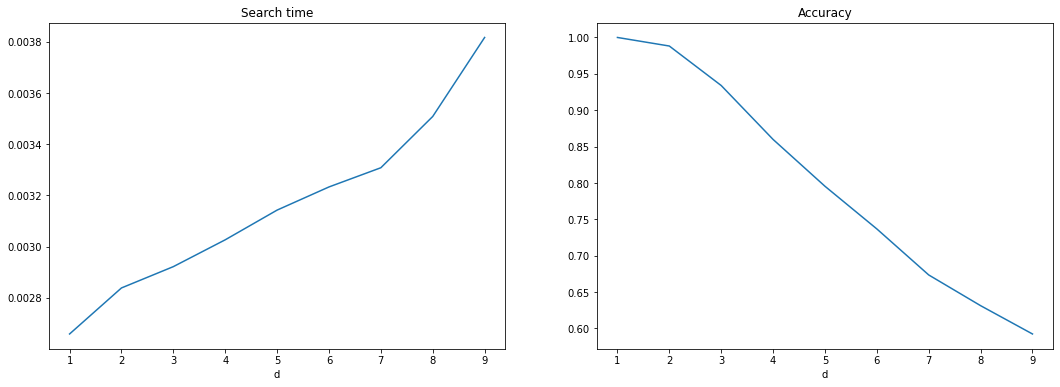

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=[18,6])
plt.subplot(1,2,1)
plt.title('Search time')
plt.xlabel('d')
plt.plot(list(r),search_times)
plt.subplot(1,2,2)
plt.title('Accuracy')
plt.xlabel('d')
plt.plot(list(r),acc_list)
plt.show()


In [ ]:
import numpy as np
#varying a, number of clusters to search over
fit_times=[]
search_times=[]
acc_list=[]
r=range(1,20)

for a in r:
  temp_search=[]
  temp_acc=[]
  print('Testing a =',str(a))
  for _ in range(10):
  
    start=time.time()
    t=ivf()
    t.fit(x,a=a)
    fit_times.append(time.time()-start)
    start=time.time()
    z=t.kneighbors(y)
    temp_search.append(time.time()-start)
    acc=accuracy(z,ground_truth[:,:k]) #naive calculation
    temp_acc.append(float(acc))
  acc_list.append(np.mean(temp_acc))
  search_times.append(np.mean(temp_search))

Testing a = 1
Testing a = 2
Testing a = 3
Testing a = 4
Testing a = 5
Testing a = 6
Testing a = 7
Testing a = 8
Testing a = 9
Testing a = 10
Testing a = 11
Testing a = 12
Testing a = 13
Testing a = 14
Testing a = 15
Testing a = 16
Testing a = 17
Testing a = 18
Testing a = 19


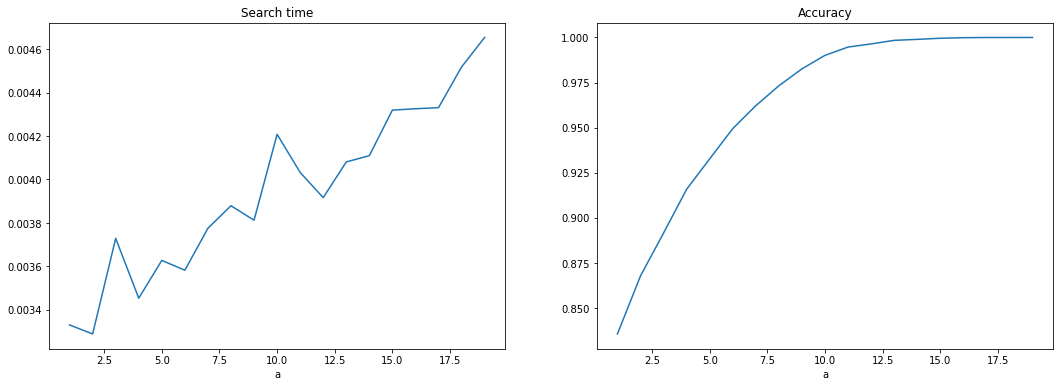

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=[18,6])
plt.subplot(1,2,1)
plt.title('Search time')
plt.xlabel('a')
plt.plot(list(r),search_times)
plt.subplot(1,2,2)
plt.title('Accuracy')
plt.xlabel('a')
plt.plot(list(r),acc_list)
plt.show()


In [ ]:
import numpy as np
#varying a, number of clusters to search over
fit_times=[]
search_times=[]
acc_list=[]
r=range(5,50)

for c in r:
  temp_search=[]
  temp_acc=[]
  print('Testing clusters =',str(c))
  for _ in range(10):
  
    start=time.time()
    t=ivf()
    t.fit(x,clusters=c)
    fit_times.append(time.time()-start)
    start=time.time()
    z=t.kneighbors(y)
    temp_search.append(time.time()-start)
    acc=accuracy(z,ground_truth[:,:k]) #naive calculation
    temp_acc.append(float(acc))
  acc_list.append(np.mean(temp_acc))
  search_times.append(np.mean(temp_search))

Testing clusters = 5
Testing clusters = 6
Testing clusters = 7
Testing clusters = 8
Testing clusters = 9
Testing clusters = 10
Testing clusters = 11
Testing clusters = 12
Testing clusters = 13
Testing clusters = 14
Testing clusters = 15
Testing clusters = 16
Testing clusters = 17
Testing clusters = 18
Testing clusters = 19
Testing clusters = 20
Testing clusters = 21
Testing clusters = 22
Testing clusters = 23
Testing clusters = 24
Testing clusters = 25
Testing clusters = 26
Testing clusters = 27
Testing clusters = 28
Testing clusters = 29
Testing clusters = 30
Testing clusters = 31
Testing clusters = 32
Testing clusters = 33
Testing clusters = 34
Testing clusters = 35
Testing clusters = 36
Testing clusters = 37
Testing clusters = 38
Testing clusters = 39
Testing clusters = 40
Testing clusters = 41
Testing clusters = 42
Testing clusters = 43
Testing clusters = 44
Testing clusters = 45
Testing clusters = 46
Testing clusters = 47
Testing clusters = 48
Testing clusters = 49


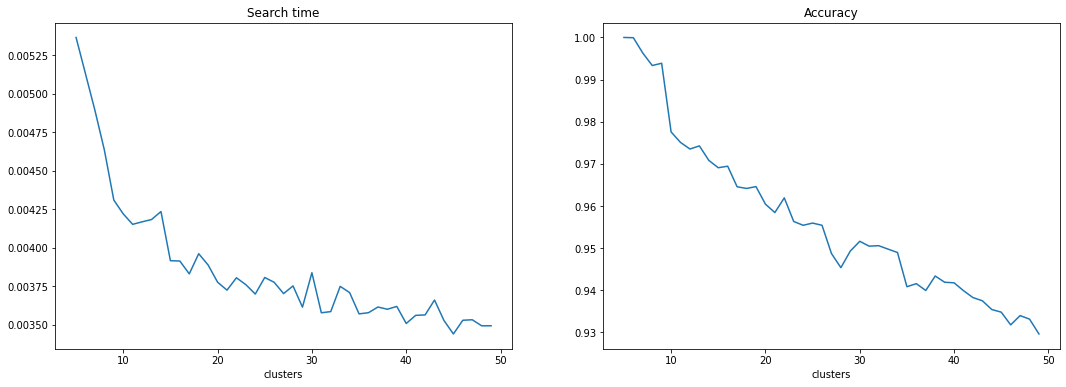

In [ ]:
plt.figure(figsize=[18,6])
plt.subplot(1,2,1)
plt.title('Search time')
plt.xlabel('clusters')
plt.plot(list(r),search_times)
plt.subplot(1,2,2)
plt.title('Accuracy')
plt.xlabel('clusters')
plt.plot(list(r),acc_list)
plt.show()


In [ ]:
#varying a, number of clusters to search over
fit_times=[]
search_times=[]
acc_list=[]
r=range(5,30)

for n in r:
  temp_search=[]
  temp_acc=[]
  print('Testing Niter =',str(n))
  for _ in range(10):
  
    start=time.time()
    t=ivf()
    t.fit(x,Niter=n)
    fit_times.append(time.time()-start)
    start=time.time()
    z=t.kneighbors(y)
    temp_search.append(time.time()-start)
    acc=accuracy(z,ground_truth[:,:k])
    temp_acc.append(float(acc))
  acc_list.append(np.mean(temp_acc))
  search_times.append(np.mean(temp_search))

Testing Niter = 5
Testing Niter = 6
Testing Niter = 7
Testing Niter = 8
Testing Niter = 9
Testing Niter = 10
Testing Niter = 11
Testing Niter = 12
Testing Niter = 13
Testing Niter = 14
Testing Niter = 15
Testing Niter = 16
Testing Niter = 17
Testing Niter = 18
Testing Niter = 19
Testing Niter = 20
Testing Niter = 21
Testing Niter = 22
Testing Niter = 23
Testing Niter = 24
Testing Niter = 25
Testing Niter = 26
Testing Niter = 27
Testing Niter = 28
Testing Niter = 29


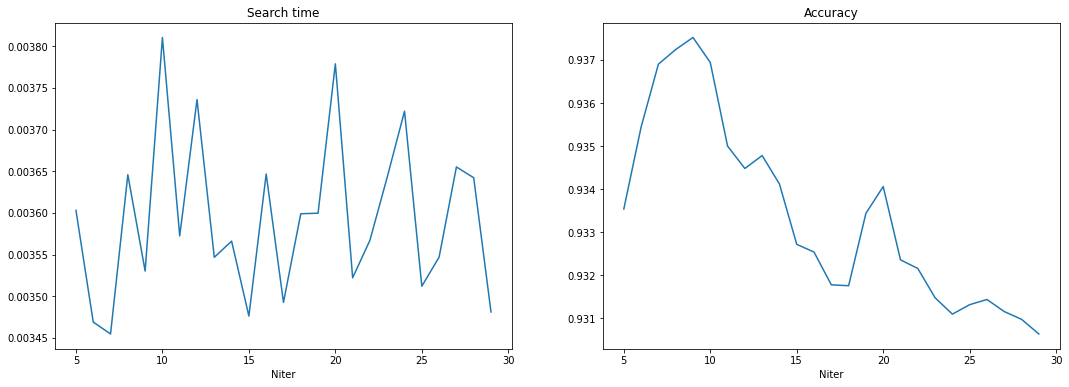

In [ ]:
plt.figure(figsize=[18,6])
plt.subplot(1,2,1)
plt.title('Search time')
plt.xlabel('Niter')
plt.plot(list(r),search_times)
plt.subplot(1,2,2)
plt.title('Accuracy')
plt.xlabel('Niter')
plt.plot(list(r),acc_list)
plt.show()


In [ ]:
#varying a, number of clusters to search over
fit_times=[]
search_times=[]
acc_list=[]
r=range(1,20)

for k in r:
  temp_search=[]
  temp_acc=[]
  print('Testing K =',str(k))
  for _ in range(10):
  
    start=time.time()
    t=ivf(k=k)
    t.fit(x)
    fit_times.append(time.time()-start)
    start=time.time()
    z=t.kneighbors(y)
    temp_search.append(time.time()-start)
    acc=accuracy(z,ground_truth[:,:k]) #naive calculation
    temp_acc.append(float(acc))
  acc_list.append(np.mean(temp_acc))
  search_times.append(np.mean(temp_search))

Testing K = 1
Testing K = 2
Testing K = 3
Testing K = 4
Testing K = 5
Testing K = 6
Testing K = 7
Testing K = 8
Testing K = 9
Testing K = 10
Testing K = 11
Testing K = 12
Testing K = 13
Testing K = 14
Testing K = 15
Testing K = 16
Testing K = 17
Testing K = 18
Testing K = 19


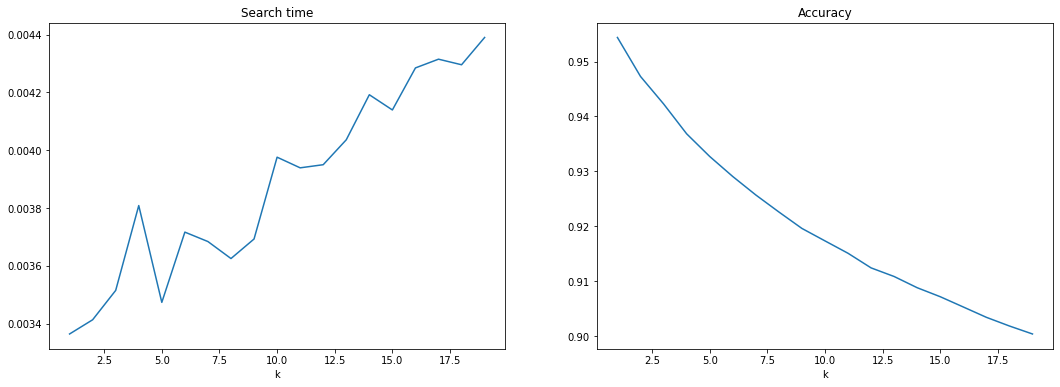

In [ ]:
plt.figure(figsize=[18,6])
plt.subplot(1,2,1)
plt.title('Search time')
plt.xlabel('k')
plt.plot(list(r),search_times)
plt.subplot(1,2,2)
plt.title('Accuracy')
plt.xlabel('k')
plt.plot(list(r),acc_list)
plt.show()


In [ ]:
#crashed upon size 10**7 
#need to fix this or we can't BM large sets
torch.manual_seed(0)
N, D, K = 10**7, 3, 50

x = 0.7 * torch.randn(N, D, dtype=dtype) + 0.3
y = 0.7 * torch.randn(N, D, dtype=dtype) + 0.3
start=time.time()
t=IVF_flat()
t.fit(x)
print('fit time',time.time()-start)
start=time.time()
t.kneighbors(y)
print('search time:',time.time()-start)